<a href="https://colab.research.google.com/github/AnnPhann2204/EEG-AD_DeepLearning/blob/main/01_Load_EEGData_EDA_FeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/My Drive'

/content/drive/My Drive


In [4]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.9 MB/s eta 0:00:00


In [5]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.1 MB/s eta 0:00:00


In [6]:
import os
import mne
import h5py
import glob
import numpy as np
from scipy.fft import fft
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

# Dataset 1: Data from Florida State University
4 groups: (A) 12 healthy elderly with eyes open by visually fixating; (B) 12 healthy elderly with eyes closed; (C) 80 probable AD patients with eyes open by visually fixating; and (D) 80 probable AD patients with eyes closed.

EEG segments of 8-s duration were recorded at a sampling frequency of 128 Hz from the 19 scalp electrodes
(Fp1, Fp2, F3, F4, F7, F8, Fz, C3, C4, Cz, P3, P4, Pz, T3, T4, T5, T6, O1, O2). The signals were previously band-limited to the range of 0.5–30 Hz and
the movement artifacts were removed from all the recordings by an EEG technician.

## Load Data

In [7]:
duration = 8
frequency = 128
channels = ['Cz', 'Fz', 'Fp1', 'Pz', 'T6', 'F7', 'F4', 'C4', 'F3', 'C3', 'Fp2', 'O2', 'T4', 'P3', 'T3', 'T5', 'F8', 'O1', 'P4']
no_channels = len(channels)

data_dirs = [
    ('/content/drive/My Drive/EEG_data/AD/Eyes_closed/', 'AD'),
    ('/content/drive/My Drive/EEG_data/AD/Eyes_open/', 'AD'),
    ('/content/drive/My Drive/EEG_data/Healthy/Eyes_open/', 'Healthy'),
    ('/content/drive/My Drive/EEG_data/Healthy/Eyes_closed/', 'Healthy')
]


In [8]:

for base_dir, label in data_dirs:
  print(base_dir)
  print(str(len(glob.glob(base_dir+ "/*/"))) + " folders found")

/content/drive/My Drive/EEG_data/AD/Eyes_closed/
80 folders found
/content/drive/My Drive/EEG_data/AD/Eyes_open/
80 folders found
/content/drive/My Drive/EEG_data/Healthy/Eyes_open/
11 folders found
/content/drive/My Drive/EEG_data/Healthy/Eyes_closed/
12 folders found


In [9]:
sample_channel = 'Cz.txt'
folder_path = '/content/drive/My Drive/EEG_data/AD/Eyes_closed/Paciente76'

txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
print(f"Number of .txt files in '{folder_path}': {len(txt_files)}")

eeg_signal_ad = np.loadtxt(os.path.join(folder_path, sample_channel))
print(f"Shape of file '{sample_channel}' is: {eeg_signal_ad.shape}")

eeg_signal_hc = np.loadtxt(os.path.join('/content/drive/My Drive/EEG_data/Healthy/Eyes_closed/Paciente1', sample_channel))

Number of .txt files in '/content/drive/My Drive/EEG_data/AD/Eyes_closed/Paciente76': 21
Shape of file 'Cz.txt' is: (1024,)


**Remark:**

* Folder for each patient will include 19-21 .txt files.

* Each .txt file is corresponding to 1 channel, and includes 1024 samples (sampling rate 128 * 8 seconds)

In [10]:
raw_data = []
labels = []
for base_dir, label in data_dirs:
    patient_folders = os.listdir(base_dir)
    for patient_folder in patient_folders:
        patient_path = os.path.join(base_dir, patient_folder)

        if os.path.isdir(patient_path):
            eeg_signals = {}
            for channel in channels:
                file_path = os.path.join(patient_path, f"{channel}.txt")
                if os.path.exists(file_path):
                    eeg_signal = np.loadtxt(file_path)
                    eeg_signals[channel] = eeg_signal
            eeg_df = pd.DataFrame(eeg_signals)
            raw_data.append(eeg_df)
            labels.append(label)


# Concatenate all patient DataFrames into one large DataFrame
print(f"Shape of raw data {len(raw_data)}")


Shape of raw data 183


In [11]:
pd.concat(raw_data, ignore_index=True)

Cz         Fz        Fp1         Pz        T6         F7  \
0       13.008000   1.320100  -3.948200  12.238000   4.35900  -3.929100   
1       15.610000   4.620500  -5.890000  14.815000   8.84620  -1.996800   
2       20.813000  13.861000  -3.948200  14.815000   7.56410  -1.352700   
3       22.764000  21.782000   3.818800  11.594000   5.64100   7.020900   
4       23.415001  22.441999  -1.359200  11.594000   6.92310   7.665100   
...           ...        ...        ...        ...       ...        ...   
187387  -8.133300 -24.510000 -20.792000  10.050000   5.98370 -18.693001   
187388 -10.133000 -30.392000 -24.752001  20.101000  11.83700 -22.614000   
187389 -10.133000 -31.372999 -30.693001  21.106001  10.86200 -24.575001   
187390 -14.133000 -29.412001 -34.653000   4.020100  -0.84553 -31.438000   
187391 -14.133000 -23.528999 -35.644001 -13.065000 -13.52800 -31.438000   

               F4        C4         F3         C3        Fp2       O2  \
0        4.508900   7.11110  -4.813000   8.679200  -3.268000   5.6508   
1        6.441200  13.46000   3.642300   9.937100  -2.614400   7.5556   
2       12.238000  13.46000  -1.561000   9.937100   1.960800   5.0159   
3       18.035000  12.82500  13.398000   4.276700   7.843100   4.3810   
4       19.323999  13.46000  13.398000   7.421400   2.614400   4.3810   
...           ...       ...        ...        ...        ...      ...   
187387 -20.305000   7.00340 -23.780001 -13.861000 -21.424000   2.0361   
187388 -27.410999   5.99330 -28.934999 -17.822001 -26.278000  13.8590   
187389 -24.365000   9.02360 -30.997000 -20.792000 -28.219999  19.7700   
187390 -23.350000  -0.06734 -34.089001 -26.733000 -30.162001   5.9770   
187391 -20.305000  -8.14810 -26.872999 -26.733000 -30.162001  -9.7865   

              T4         P3         T3        T5         F8        O1  \
0        0.06349  10.921000   5.000000   9.15030  -0.064720   1.26380   
1        5.77780  11.556000   6.282100   9.80390   7.702300   1.26380   
2        6.41270   9.650800   7.564100   8.49670   8.996800   0.00000   
3        6.41270   5.206300   7.564100   4.57520   8.996800  -1.89570   
4        4.50790   7.746000   6.923100   3.92160  20.646999  -1.26380   
...          ...        ...        ...       ...        ...       ...   
187387  -3.96750   5.050500 -19.066999   0.13072 -12.121000   0.06441   
187388  -0.06504   6.060600 -12.067000   0.13072 -15.152000  10.69200   
187389   2.86180  -1.010100  -9.066700  -4.77120 -14.141000  14.55700   
187390  -0.06504 -23.232000 -17.066999 -24.37900 -17.172001  -3.80030   
187391 -10.79700 -38.383999 -25.066999 -38.10500 -18.181999 -26.98900   

               P4  
0       10.950000  
1       16.103001  
2       15.459000  
3       12.238000  
4       11.594000  
...           ...  
187387  10.879000  
187388  23.813999  
187389  26.799000  
187390  12.869000  
187391  -6.036500  

[187392 rows x 19 columns]

**Remark:**

Stacking all samples from multiple subjects together (concatenating rows) for each channel will disregard the variability between subjects.

--> If using 2D tensor for traditional machine learning model, the approach can be: transformed each EEG sample into a feature vector, rows represent samples, columns represent the extracted features.

size: [samples, channels * features]

In [12]:

# import pandas as pd
# labels_df = pd.DataFrame(labels, columns=['Label'])
# labels_df.to_csv('labels.csv', index=False)
# with h5py.File('arrays.h5', 'w') as f:
#     for i, array in enumerate(raw_data):
#         f.create_dataset(f'array_{i}', data=array)


In [13]:
loaded_arrays = []
with h5py.File('arrays.h5', 'r') as f:
    for key in f.keys():
        loaded_arrays.append(f[key][:])

print(loaded_arrays)


[array([[13.008   ,  1.3201  , -3.9482  , ..., -0.06472 ,  1.2638  ,
        10.95    ],
       [15.61    ,  4.6205  , -5.89    , ...,  7.7023  ,  1.2638  ,
        16.103001],
       [20.813   , 13.861   , -3.9482  , ...,  8.9968  ,  0.      ,
        15.459   ],
       ...,
       [13.659   , 17.162001, 12.88    , ...,  9.644   , -3.1596  ,
        12.882   ],
       [ 9.1057  , 10.561   , 14.822   , ..., 11.586   , -5.0553  ,
        12.882   ],
       [ 9.1057  ,  6.6007  ,  0.58252 , ..., 14.175   , -3.1596  ,
        12.882   ]]), array([[ -2.9268 ,   0.98522,   6.8293 , ...,  -2.9773 ,  -6.6351 ,
          1.9324 ],
       [  3.9024 ,   5.9113 ,   8.7805 , ...,   4.7896 , -11.374  ,
         -0.96618],
       [  0.97561,   2.9557 ,   3.9024 , ...,   3.8188 , -17.062  ,
         -7.7295 ],
       ...,
       [  5.8537 ,   0.     ,   1.9512 , ...,   2.8479 ,   3.7915 ,
          9.6618 ],
       [  1.9512 ,  -3.9409 ,  -8.7805 , ...,   0.90615, -10.427  ,
          6.7633 ],
     

**Remark**:

EEG Data of each patient will be stored in an array having 1024 rows x 19 columns. At the end, there are 183 such arrays

## Visualize raw EEG **signal**

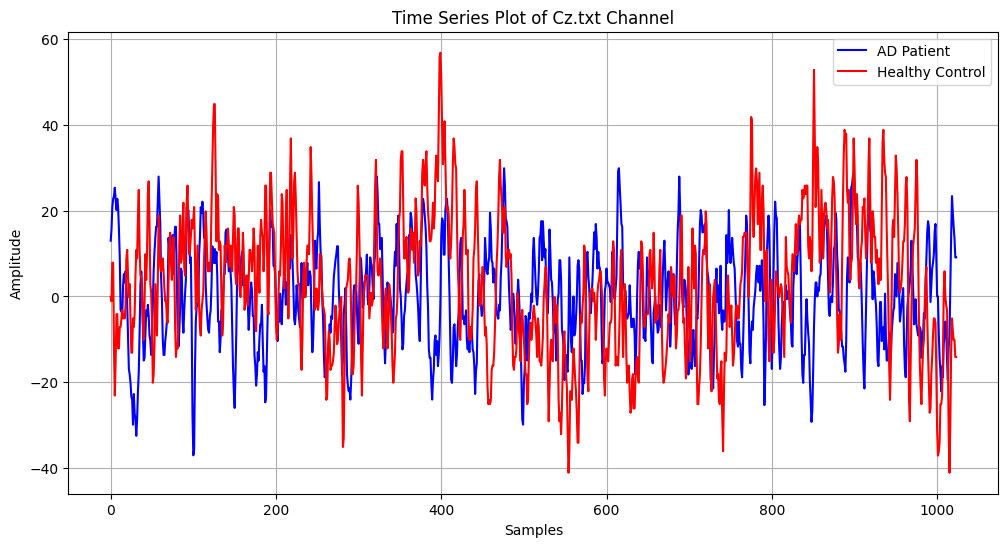

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(eeg_signal_ad, color='blue', label='AD Patient')
plt.plot(eeg_signal_hc, color = 'red', label='Healthy Control')
plt.title(f'Time Series Plot of {sample_channel} Channel')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.show()

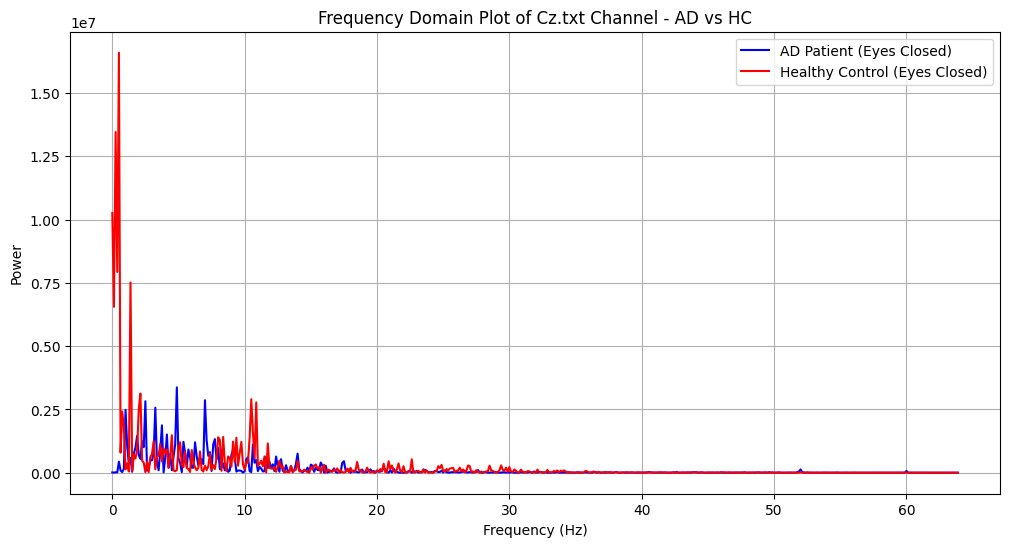

In [15]:
# Compute the Fast Fourier Transform (FFT)
fft_values_ad = np.fft.fft(eeg_signal_ad)
fft_values_hc = np.fft.fft(eeg_signal_hc)

freqs = np.fft.fftfreq(len(eeg_signal_ad), d=1/128)
positive_freqs = freqs[:len(freqs) // 2]
psd_ad = np.abs(fft_values_ad[:len(fft_values_ad) // 2])**2
psd_hc = np.abs(fft_values_hc[:len(fft_values_hc) // 2])**2

plt.figure(figsize=(12, 6))
plt.plot(positive_freqs, psd_ad, color='blue', label='AD Patient (Eyes Closed)')
plt.plot(positive_freqs, psd_hc, color='red', label='Healthy Control (Eyes Closed)')
plt.title(f'Frequency Domain Plot of {sample_channel} Channel - AD vs HC')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid()
plt.legend()
plt.show()

In [16]:
freq = 128
def mne_object(data, freq):
  info = mne.create_info(ch_names=list(data.columns),
                         sfreq=freq,
                         ch_types=['eeg']*data.shape[-1])

  data = data.apply(lambda x: x*1e-6)
  data_T = data.transpose()
  raw = mne.io.RawArray(data_T, info)

  return raw

plot_kwargs = {
    'highpass': 0.5,
    'lowpass': 30.,
    'n_channels': 19
}

AD
Creating RawArray with float64 data, n_channels=19, n_times=1024
    Range : 0 ... 1023 =      0.000 ...     7.992 secs
Ready.
Setting up band-pass filter from 0.5 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 30.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


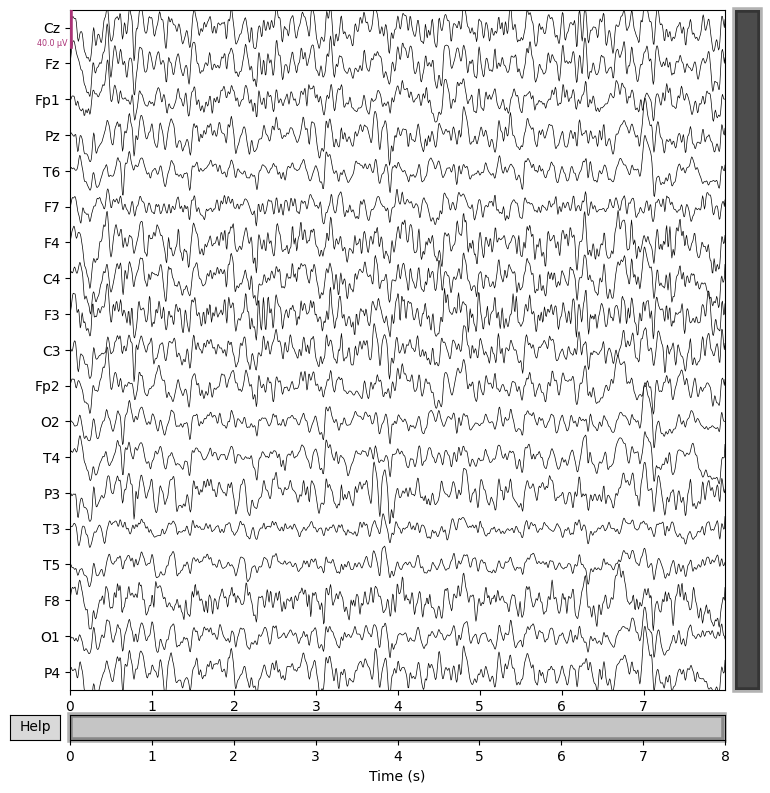

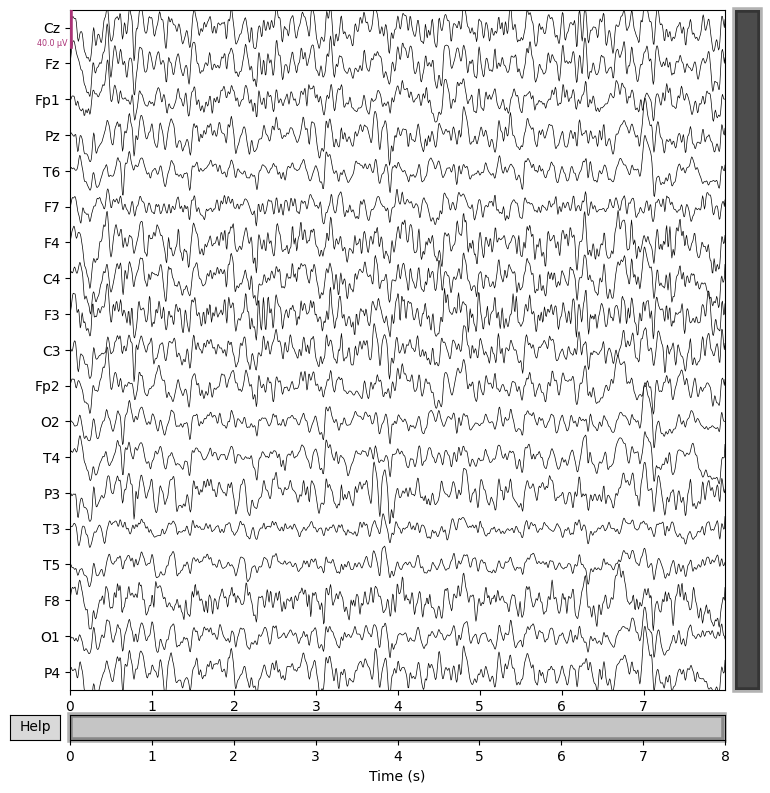

In [17]:
print(labels[0])
raw_ad = mne_object(raw_data[0],freq)
raw_ad.plot(start = 0, duration = 8, **plot_kwargs)

Healthy
Creating RawArray with float64 data, n_channels=19, n_times=1024
    Range : 0 ... 1023 =      0.000 ...     7.992 secs
Ready.
Setting up band-pass filter from 0.5 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 30.00 Hz: -6.02, -6.02 dB



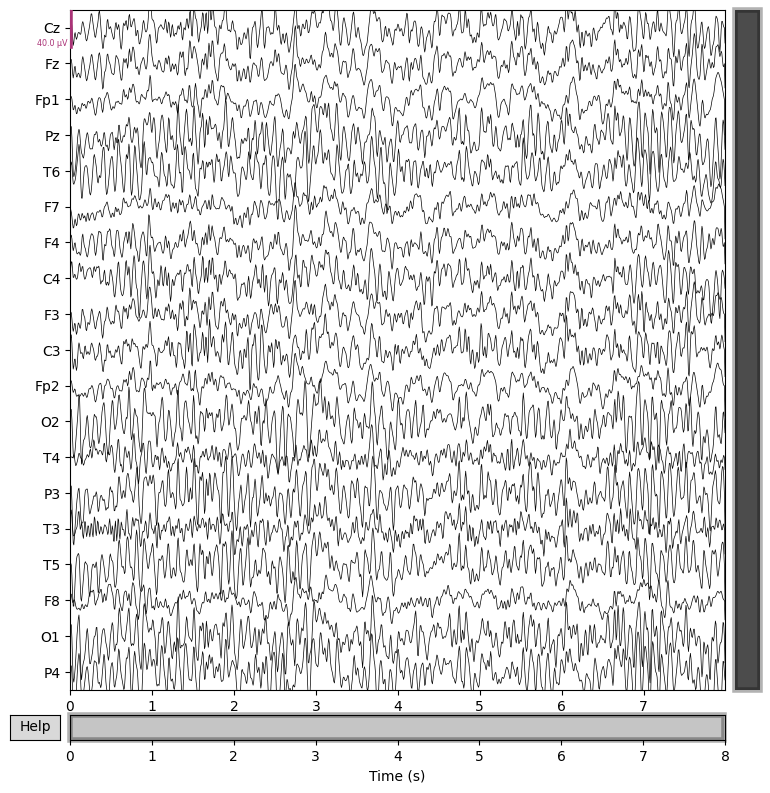

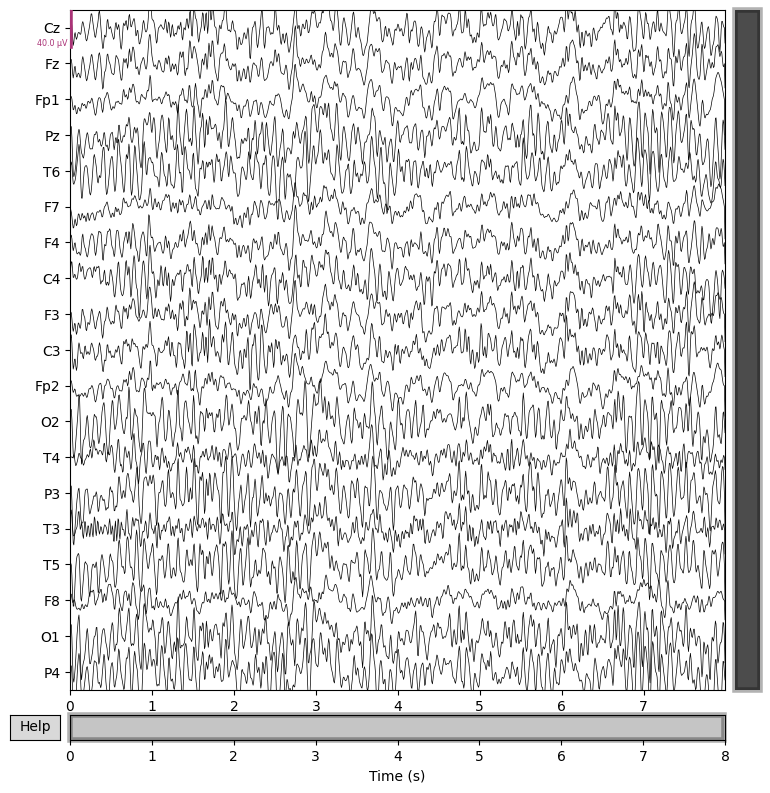

In [18]:

print(labels[182])
raw_hc = mne_object(raw_data[182],freq)
raw_hc.plot(start = 0, duration = 8, **plot_kwargs)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


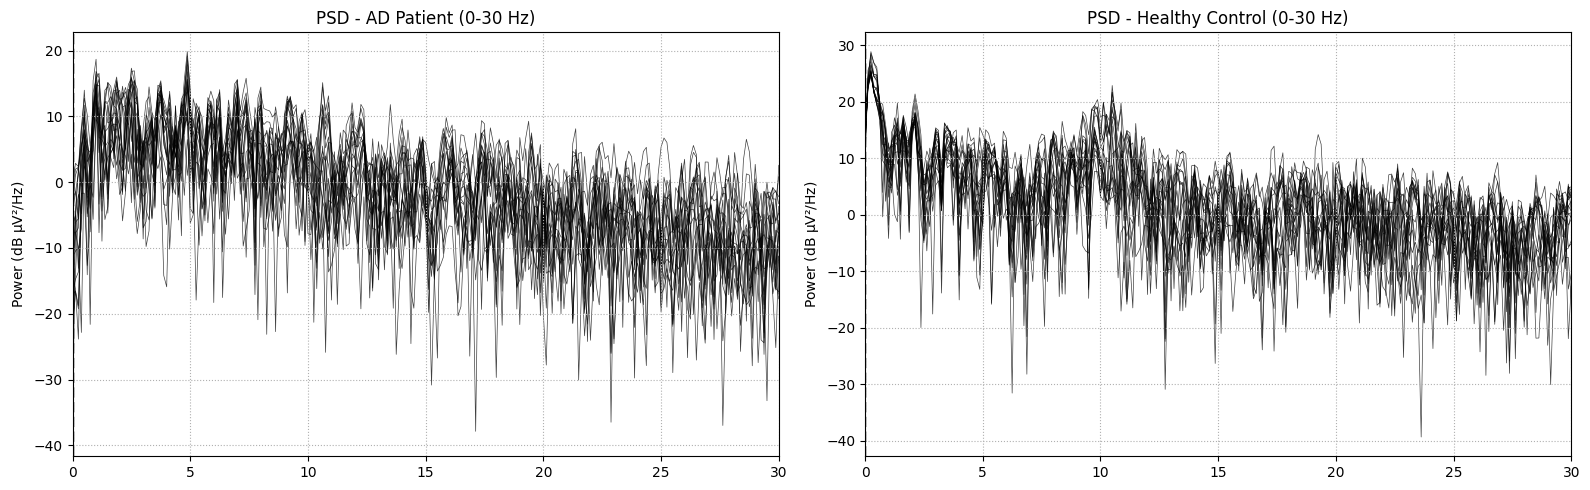

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

raw_ad.plot_psd(fmax=30, ax=axes[0], show=False)
axes[0].set_title('PSD - AD Patient (0-30 Hz)')
raw_hc.plot_psd(fmax=30, ax=axes[1], show=False)
axes[1].set_title('PSD - Healthy Control (0-30 Hz)')

plt.tight_layout()
plt.show()

NOTE: plot_psd_topomap() is a legacy function. New code should use .compute_psd().plot_topomap().
Effective window size : 8.000 (s)
converting legacy list-of-tuples input to a dict for the `bands` parameter
NOTE: plot_psd_topomap() is a legacy function. New code should use .compute_psd().plot_topomap().
Effective window size : 8.000 (s)
converting legacy list-of-tuples input to a dict for the `bands` parameter


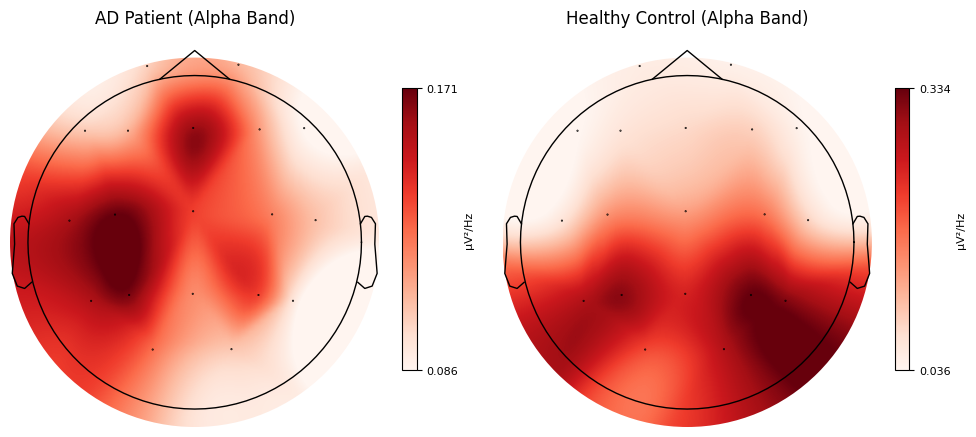

In [20]:
montage = mne.channels.make_standard_montage('standard_1020')
raw_ad.set_montage(montage)
raw_hc.set_montage(montage)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
raw_ad.plot_psd_topomap(bands=[(8, 12, 'Alpha')], normalize=True, axes=axes[0], show=False)
axes[0].set_title('AD Patient (Alpha Band)')
raw_hc.plot_psd_topomap(bands=[(8, 12, 'Alpha')], normalize=True, axes=axes[1], show=False)
axes[1].set_title('Healthy Control (Alpha Band)')

plt.tight_layout()
plt.show()

## Preparation 3D tensor data

In [21]:
window = 256
overlap = 128
oversample = True
n_channels = 19
num_classes = 2

from sklearn.preprocessing import StandardScaler, MinMaxScaler
x_data = np.empty((0, window, n_channels))
y_data = np.empty((0, 1))  # labels
subj_inputs = []  # number of inputs for every subject
print('\n### creating dataset')
tot_rows = 0

for i in range(0,len(raw_data)):
  category = ('Healthy', 'AD').index(labels[i])
  subj_inputs.append(0)
  scaler = StandardScaler()
  eeg = scaler.fit_transform(raw_data[i])
  assert(eeg.shape[1] == n_channels)
  tot_rows += len(eeg)
  # compute number of sliding windows
  i = 0
  num_w = 0
  while i + window  <= len(eeg):
    i += (window - overlap)
    num_w += 1
  # compute actual windows
  x_data_part = np.empty((num_w, window, n_channels))
  i = 0
  for w in range(0, num_w):
    x_data_part[w] = eeg[i:i + window]
    i += (window - overlap)
    if False:
      for cc in range(0, n_channels):
        x_data_part[w, 0, cc] = 1000 * (len(subj_inputs) - 1) + cc
  x_data = np.vstack((x_data, x_data_part))
  y_data = np.vstack((y_data, np.full((num_w, 1), category)))
  subj_inputs[-1] += num_w

print('\ntot samples:', tot_rows)
print('x_data:', x_data.shape)
print('y_data:', y_data.shape)
print('windows per subject:', subj_inputs)
print('class distribution:', [np.sum(y_data == cl) for cl in range(0, num_classes)])


### creating dataset

tot samples: 187392
x_data: (1281, 256, 19)
y_data: (1281, 1)
windows per subject: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
class distribution: [161, 1120]


## Feature Extraction

In [22]:

import scipy.stats as stats
from scipy.signal import welch
from scipy.stats import skew, kurtosis
import pywt


In [23]:
# eeg_signal = raw_data[0]
eeg_signal = loaded_arrays[0]
eeg_signal

array([[13.008   ,  1.3201  , -3.9482  , ..., -0.06472 ,  1.2638  ,
        10.95    ],
       [15.61    ,  4.6205  , -5.89    , ...,  7.7023  ,  1.2638  ,
        16.103001],
       [20.813   , 13.861   , -3.9482  , ...,  8.9968  ,  0.      ,
        15.459   ],
       ...,
       [13.659   , 17.162001, 12.88    , ...,  9.644   , -3.1596  ,
        12.882   ],
       [ 9.1057  , 10.561   , 14.822   , ..., 11.586   , -5.0553  ,
        12.882   ],
       [ 9.1057  ,  6.6007  ,  0.58252 , ..., 14.175   , -3.1596  ,
        12.882   ]])

### Time-domain Features

In [24]:
def extract_time_domain_features(signal):
    mean = np.mean(signal)
    std_dev = np.std(signal)
    var = np.var(signal)
    skw = skew(signal)
    krt = kurtosis(signal)
    return [mean, std_dev, var, skw, krt]

In [25]:
time_domain_features = []

for channel in range(eeg_signal.shape[1]):
    signal = eeg_signal[:, channel]
    time_features = extract_time_domain_features(signal)
    channel_features = list(time_features)
    time_domain_features.append(channel_features)

time_domain_features = np.array(time_domain_features)
print("Extracted Features Shape:", time_domain_features.shape)
time_domain_features

Extracted Features Shape: (19, 5)


array([[ 1.14329004e-01,  1.17090773e+01,  1.37102490e+02,
        -3.49799637e-02, -2.95279373e-01],
       [ 1.71462709e-01,  1.20452043e+01,  1.45086946e+02,
         8.82401874e-02,  1.07201655e-01],
       [ 4.97853886e-01,  1.02096653e+01,  1.04237265e+02,
         2.68339439e-01,  7.09932414e-01],
       [ 1.45928780e-01,  1.07546918e+01,  1.15663395e+02,
         1.90430032e-01,  1.85535737e-01],
       [-6.12728711e-02,  8.95708963e+00,  8.02294547e+01,
         2.79692984e-01,  1.32682807e+00],
       [ 2.91630872e-01,  8.01379044e+00,  6.42208373e+01,
        -1.27102812e-01, -8.46380263e-02],
       [ 2.51503662e-02,  1.39084071e+01,  1.93443787e+02,
         5.93424908e-02,  2.50584496e-01],
       [ 4.69941426e-02,  1.21701127e+01,  1.48111644e+02,
        -9.02843780e-03, -2.58088895e-01],
       [ 7.87701855e-03,  1.29459222e+01,  1.67596902e+02,
        -5.32778313e-02, -5.57434074e-02],
       [ 2.04652451e-01,  1.05655858e+01,  1.11631604e+02,
        -1.12573330e-01

### Frequency-domain Features

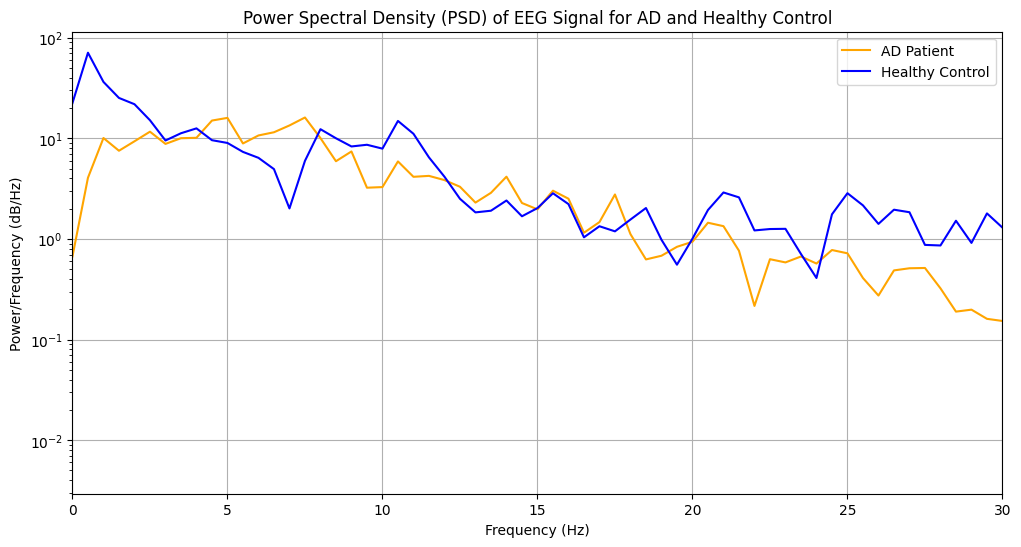

In [26]:
from scipy.signal import welch
freqs_ad, psd_ad = welch(eeg_signal_ad, fs=128)

freqs_hc, psd_hc = welch(eeg_signal_hc, fs=128)

plt.figure(figsize=(12, 6))
plt.semilogy(freqs_ad, psd_ad, color='orange', label='AD Patient')
plt.semilogy(freqs_hc, psd_hc, color='blue', label='Healthy Control')

plt.title('Power Spectral Density (PSD) of EEG Signal for AD and Healthy Control')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.xlim([0, 30])
plt.grid()
plt.legend()
plt.show()


In [27]:
print("spectral_entropy of AD",-np.sum(psd_ad * np.log(psd_ad + 1e-10)))
print("spectral_entropy of HC",-np.sum(psd_hc * np.log(psd_hc + 1e-10)))

spectral_entropy of AD -489.4272589021302
spectral_entropy of HC -1075.6932427617733


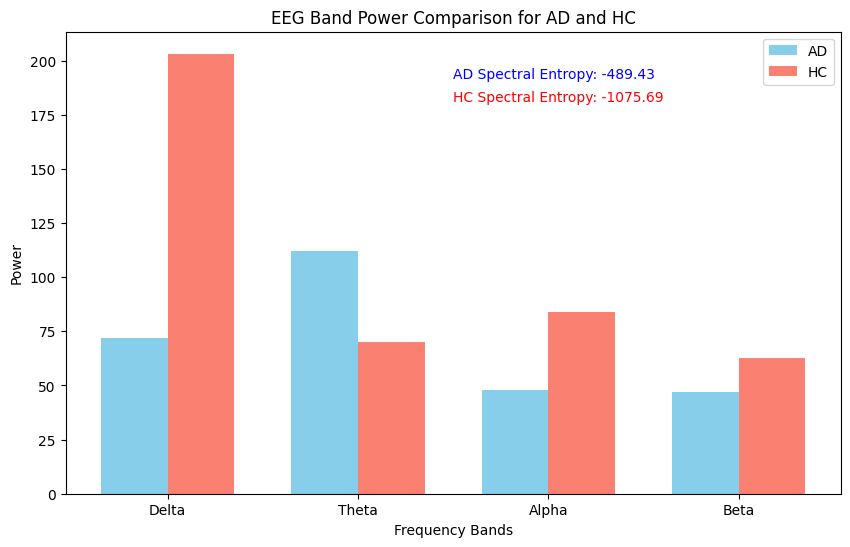

In [28]:
delta_band = (0.5, 4)
theta_band = (4, 8)
alpha_band = (8, 12)
beta_band = (12, 30)

def bandpower(freqs, psd, band):
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.sum(psd[idx_band])

delta_power_ad = bandpower(freqs_ad, psd_ad, delta_band)
theta_power_ad  = bandpower(freqs_ad, psd_ad, theta_band)
alpha_power_ad = bandpower(freqs_ad, psd_ad, alpha_band)
beta_power_ad  = bandpower(freqs_ad, psd_ad, beta_band)

delta_power_hc = bandpower(freqs_hc, psd_hc, delta_band)
theta_power_hc = bandpower(freqs_hc, psd_hc, theta_band)
alpha_power_hc = bandpower(freqs_hc, psd_hc, alpha_band)
beta_power_hc = bandpower(freqs_hc, psd_hc, beta_band)

bands = ['Delta', 'Theta', 'Alpha', 'Beta']
ad_powers = [delta_power_ad, theta_power_ad, alpha_power_ad, beta_power_ad]
hc_powers = [delta_power_hc, theta_power_hc, alpha_power_hc, beta_power_hc]


spectral_entropy_ad = -np.sum(psd_ad * np.log(psd_ad + 1e-10))
spectral_entropy_hc = -np.sum(psd_hc * np.log(psd_hc + 1e-10))

x = range(len(bands))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, ad_powers, width=bar_width, label='AD', color='skyblue')
plt.bar([p + bar_width for p in x], hc_powers, width=bar_width, label='HC', color='salmon')
plt.xlabel('Frequency Bands')
plt.ylabel('Power')
plt.title('EEG Band Power Comparison for AD and HC')
plt.xticks([p + bar_width / 2 for p in x], bands)

plt.annotate(f'AD Spectral Entropy: {spectral_entropy_ad:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', color='blue')
plt.annotate(f'HC Spectral Entropy: {spectral_entropy_hc:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', color='red')

plt.legend()
plt.show()

In [29]:
def extract_frequency_domain_features(signal, fs=128):
    freqs, psd = welch(signal, fs=fs)
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 12)
    beta_band = (12, 30)

    def bandpower(freqs, psd, band):
        idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
        return np.sum(psd[idx_band])

    delta_power = bandpower(freqs, psd, delta_band)
    theta_power = bandpower(freqs, psd, theta_band)
    alpha_power = bandpower(freqs, psd, alpha_band)
    beta_power = bandpower(freqs, psd, beta_band)
    spectral_entropy = -np.sum(psd * np.log(psd + 1e-10))

    return [delta_power, theta_power, alpha_power, beta_power, spectral_entropy]

In [30]:
features = []

for channel in range(eeg_signal.shape[1]):
    signal = eeg_signal[:, channel]
    freq_features = extract_frequency_domain_features(signal, fs=128)
    channel_features = list(freq_features)
    features.append(channel_features)

features = np.array(features)
print("Extracted Features Shape:", features.shape)
features

Extracted Features Shape: (19, 5)


array([[  71.71423044,  111.95682446,   48.08015575,   46.82814623,
        -489.4272589 ],
       [  74.02269708,   93.68718443,   61.50090694,   38.52502498,
        -490.80450215],
       [  78.5576688 ,   47.4714969 ,   26.51401884,   25.70489613,
        -257.26761868],
       [  91.43150309,  111.94828034,   34.91606578,   28.82244413,
        -495.61298666],
       [  73.85653808,   64.50128901,   16.67715066,   16.88558057,
        -272.54644735],
       [  43.26235821,   28.25896403,   18.26062017,   20.06416551,
         -85.30517413],
       [ 104.97878798,   92.46113522,   47.0947037 ,   54.6447931 ,
        -579.27596816],
       [ 101.68738965,  100.92052952,   36.68771876,   42.95248086,
        -506.63609778],
       [  52.48302203,   68.74675022,   47.42068247,   74.31140943,
        -421.05563134],
       [  59.34494316,   87.16873591,   36.07183937,   37.51645944,
        -347.00830221],
       [ 122.54620477,   63.88619289,   27.18185288,   23.42725349,
        -469

### Time-Frequency Domain Features

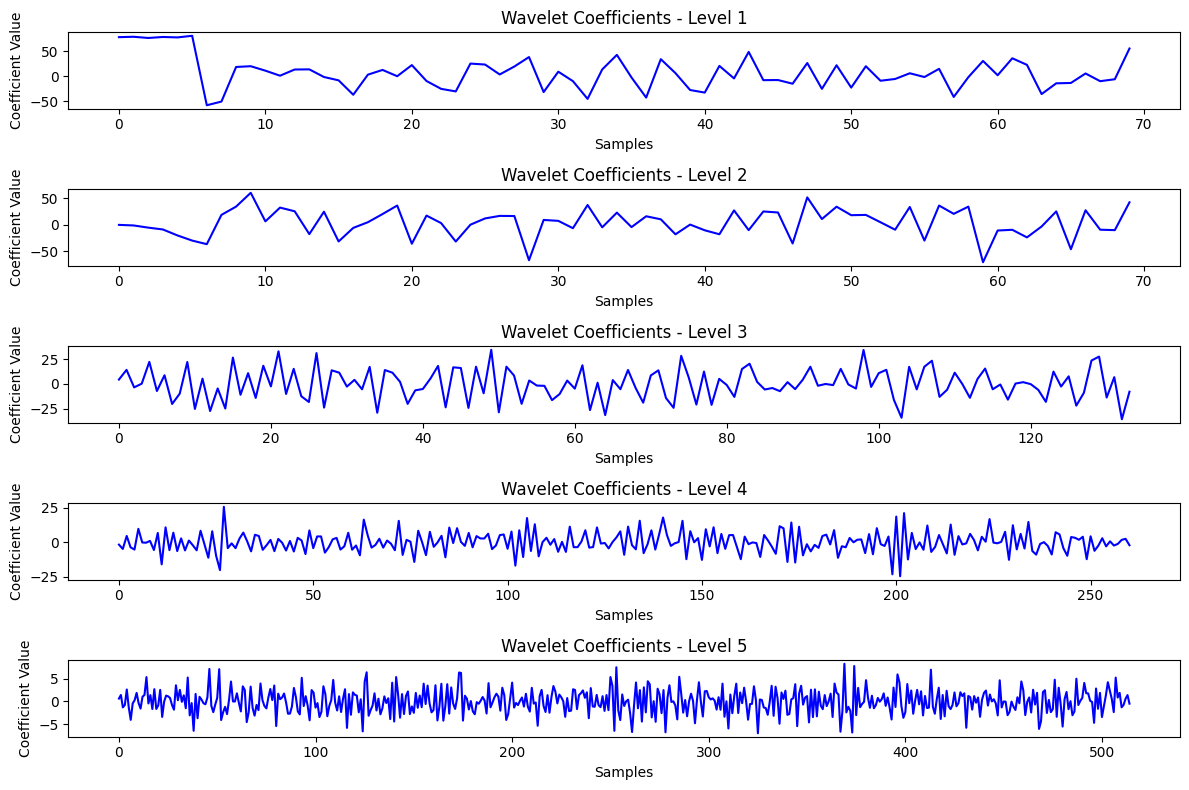

In [51]:
coeffs_ad = pywt.wavedec(eeg_signal_ad, wavelet='db4', level=4)

# Plot wavelet coefficients for each level
plt.figure(figsize=(12, 8))
for i, coeff in enumerate(coeffs_ad):
    plt.subplot(len(coeffs_ad), 1, i + 1)
    plt.plot(coeff, color='b')
    plt.title(f'Wavelet Coefficients - Level {i + 1}')
    plt.xlabel('Samples')
    plt.ylabel('Coefficient Value')
plt.tight_layout()


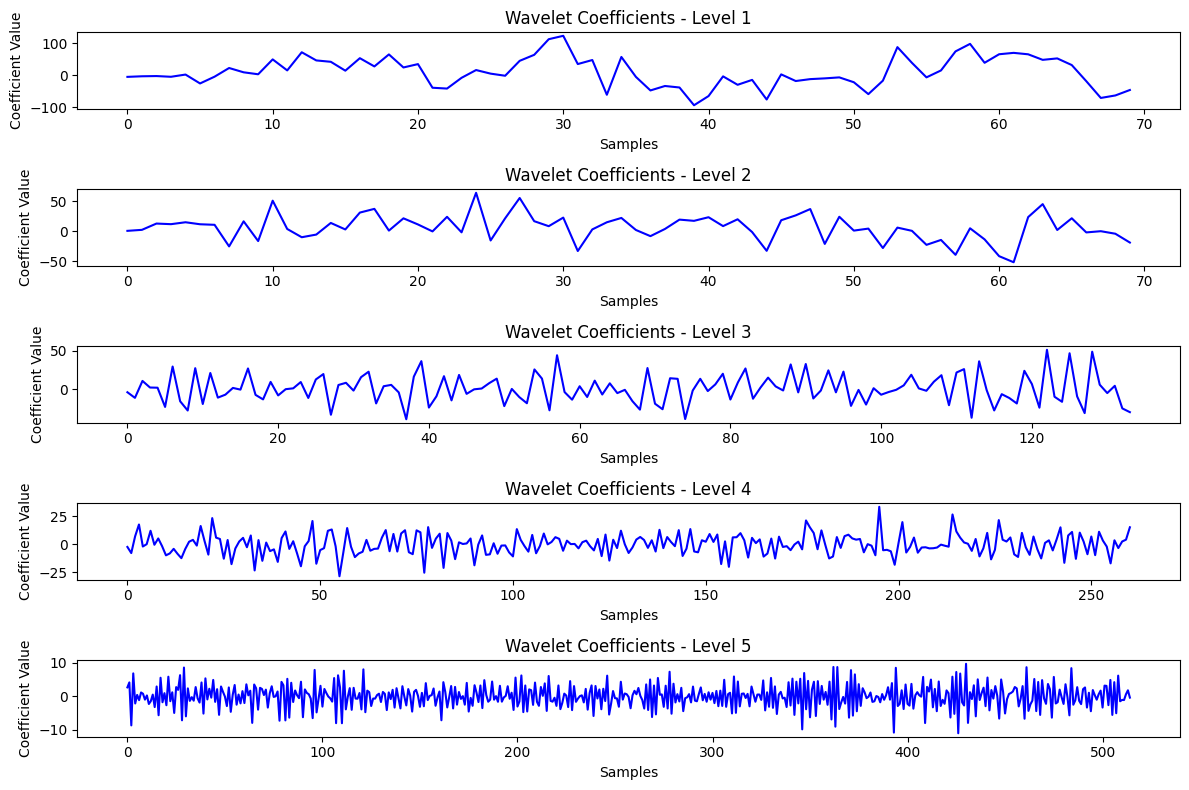

In [31]:
coeffs_hc = pywt.wavedec(eeg_signal_hc, wavelet='db4', level=4)

# Plot wavelet coefficients for each level
plt.figure(figsize=(12, 8))
for i, coeff in enumerate(coeffs_hc):
    plt.subplot(len(coeffs_hc), 1, i + 1)
    plt.plot(coeff, color='b')
    plt.title(f'Wavelet Coefficients - Level {i + 1}')
    plt.xlabel('Samples')
    plt.ylabel('Coefficient Value')
plt.tight_layout()


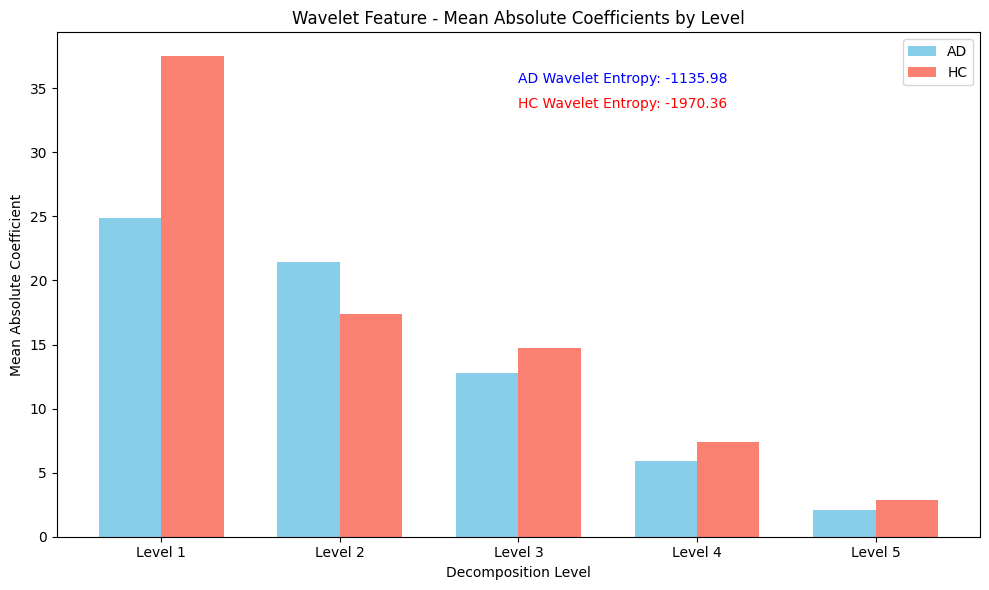

In [33]:

wavelet_features_ad = [np.mean(np.abs(coeff)) for coeff in coeffs]
wavelet_entropy_ad = -np.sum(np.abs(coeffs[-1]) * np.log(np.abs(coeffs[-1]) + 1e-10))
wavelet_features_hc = [np.mean(np.abs(coeff)) for coeff in coeffs_hc]
wavelet_entropy_hc = -np.sum(np.abs(coeffs_hc[-1]) * np.log(np.abs(coeffs_hc[-1]) + 1e-10))

levels = [f'Level {i + 1}' for i in range(len(wavelet_features_ad))]
x = np.arange(len(levels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wavelet_features_ad, width, label='AD', color='skyblue')
plt.bar(x + width/2, wavelet_features_hc, width, label='HC', color='salmon')

plt.title('Wavelet Feature - Mean Absolute Coefficients by Level')
plt.xlabel('Decomposition Level')
plt.ylabel('Mean Absolute Coefficient')
plt.xticks(x, levels)
plt.legend()

plt.annotate(f'AD Wavelet Entropy: {wavelet_entropy_ad:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', color='blue')
plt.annotate(f'HC Wavelet Entropy: {wavelet_entropy_hc:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', color='red')

plt.tight_layout()
plt.show()

In [48]:
for coeff in coeffs:
  print(coeff)

[ 7.78209476e+01  7.86111953e+01  7.62091317e+01  7.81915019e+01
  7.73237364e+01  8.05253478e+01 -5.78584321e+01 -5.05135000e+01
  1.84114002e+01  1.99327675e+01  1.10305795e+01  1.01493376e+00
  1.33586517e+01  1.36501015e+01 -1.57084431e+00 -8.21582989e+00
 -3.69181639e+01  3.10823612e+00  1.25309502e+01 -6.26969288e-03
  2.21553154e+01 -9.50917378e+00 -2.52042021e+01 -3.02867427e+01
  2.51690166e+01  2.32535002e+01  3.48802900e+00  1.93425377e+01
  3.81917045e+01 -3.15691967e+01  8.99912249e+00 -9.85481288e+00
 -4.51478485e+01  1.35272342e+01  4.25300231e+01 -2.55331803e+00
 -4.25749668e+01  3.39467860e+01  6.14441360e+00 -2.74853354e+01
 -3.26326394e+01  2.05437613e+01 -4.41365760e+00  4.84514918e+01
 -7.85538505e+00 -7.59704598e+00 -1.49420592e+01  2.62859383e+01
 -2.51774671e+01  2.18273630e+01 -2.27034873e+01  1.98969072e+01
 -9.03114991e+00 -5.48452438e+00  5.87570381e+00 -1.63551705e+00
  1.47363856e+01 -4.13015992e+01 -1.84872952e+00  3.04516630e+01
  1.95705709e+00  3.57225

In [34]:
def extract_time_frequency_features(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    wavelet_features = [np.mean(np.abs(coeff)) for coeff in coeffs]
    wavelet_entropy = -np.sum(np.abs(coeffs[-1]) * np.log(np.abs(coeffs[-1]) + 1e-10))
    return wavelet_features + [wavelet_entropy]


In [35]:
features = []

for channel in range(eeg_signal.shape[1]):
    signal = eeg_signal[:, channel]
    time_freq_features = extract_time_frequency_features(signal)
    # Combine all features
    channel_features = time_freq_features
    features.append(channel_features)

# Convert list to 2D array (channels x features)
features = np.array(features)
print("Extracted Features Shape:", features.shape)
features

Extracted Features Shape: (19, 6)


array([[ 2.48642629e+01,  2.14176870e+01,  1.27981580e+01,
         5.92309953e+00,  2.11619696e+00, -1.13597753e+03],
       [ 2.36301914e+01,  2.07867409e+01,  1.38991230e+01,
         5.28219396e+00,  2.28057826e+00, -1.30110218e+03],
       [ 2.01135453e+01,  1.44177578e+01,  8.96241169e+00,
         4.68844027e+00,  3.36095237e+00, -2.55945463e+03],
       [ 2.39205415e+01,  1.98444054e+01,  1.01902574e+01,
         4.78358902e+00,  1.72634212e+00, -7.66560837e+02],
       [ 1.84819729e+01,  1.50185129e+01,  7.91690954e+00,
         3.08583741e+00,  1.63840803e+00, -6.69851726e+02],
       [ 1.52192753e+01,  1.12402144e+01,  7.49546682e+00,
         3.86106207e+00,  2.82993205e+00, -1.91503263e+03],
       [ 2.91085953e+01,  2.07649635e+01,  1.21190676e+01,
         7.01489701e+00,  5.75651938e+00, -6.12029826e+03],
       [ 2.68860727e+01,  1.99464926e+01,  1.06336791e+01,
         5.97888023e+00,  3.73017691e+00, -3.10898555e+03],
       [ 1.78440636e+01,  1.81497592e+01,  1.353

### Features Extraction for all samples

In [36]:
def extract_features_for_windows(eeg_data, fs=128, wavelet='db4', level=4):
    num_windows, window_size, num_channels = eeg_data.shape
    all_features = []

    for window in range(num_windows):
        window_features = []
        for channel in range(num_channels):
            signal = eeg_data[window, :, channel]

            # Extract time domain features
            time_features = extract_time_domain_features(signal)

            # Extract frequency domain features
            freq_features = extract_frequency_domain_features(signal, fs=fs)

            # Extract time-frequency domain features
            time_freq_features = extract_time_frequency_features(signal, wavelet=wavelet, level=level)

            # Combine all features for this channel
            channel_features = time_features + freq_features + time_freq_features
            window_features.append(channel_features)

        # Append features for this window
        all_features.append(window_features)

    # Convert list to 3D numpy array (num_windows x num_channels x num_features)
    all_features = np.array(all_features)
    return all_features

In [37]:
features = extract_features_for_windows(x_data)
print("Extracted Features Shape:", features.shape)
print("Extracted Features:\n", features)

Extracted Features Shape: (1281, 19, 16)
Extracted Features:
 [[[ 4.20956447e-02  1.08116699e+00  1.16892205e+00 ...  4.94302791e-01
    1.79722081e-01  3.31375374e+01]
  [ 2.79340772e-02  1.13782794e+00  1.29465241e+00 ...  3.78311200e-01
    1.79483757e-01  3.35352256e+01]
  [ 5.13860395e-02  1.12247610e+00  1.25995261e+00 ...  4.70456987e-01
    2.93616752e-01  3.70649759e+01]
  ...
  [ 1.00773045e-03  1.01594528e+00  1.03214482e+00 ...  5.05283153e-01
    4.38316236e-01  2.78117310e+01]
  [ 1.50483801e-02  1.08740714e+00  1.18245429e+00 ...  3.51823114e-01
    1.59271573e-01  3.18340862e+01]
  [ 1.01238619e-01  1.07514927e+00  1.15594596e+00 ...  3.72784066e-01
    1.51531271e-01  3.10751582e+01]]

 [[ 5.44626258e-02  9.05627558e-01  8.20161273e-01 ...  4.44706088e-01
    1.83053452e-01  3.43785679e+01]
  [ 3.32866282e-02  8.94880692e-01  8.00811453e-01 ...  3.70313608e-01
    1.93019805e-01  3.29797006e+01]
  [ 5.32586796e-03  8.64144982e-01  7.46746549e-01 ...  4.67116899e-01
   

# Dataset 2: (.npz)

Data from https://github.com/MAlessandrini-Univpm/rnn-eeg-ad.git


In [38]:
# Path to the folder
folder_path = '/content/drive/My Drive/eeg2'

# Count the number of .npz files in the folder
npz_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]
print(f"Number of .npz files in '{folder_path}': {len(npz_files)}")


Number of .npz files in '/content/drive/My Drive/eeg2': 35


In [39]:
data = np.load('eeg2/S01_AD.npz')
print(data.files)
eeg_array = data['eeg']
print(eeg_array.shape)

print(eeg_array)

['eeg']
(16, 177280)
[[25.01354003 25.01354003 25.01354003 ... 25.01354003 25.01354003
  25.01354003]
 [25.01354003 25.01354003 25.01354003 ... 25.01354003 25.01354003
  25.01354003]
 [25.01354003 25.01354003 25.01354003 ... 25.01354003 25.01354003
  25.01354003]
 ...
 [25.01354003 25.01354003 25.01354003 ... 25.01354003 25.01354003
  25.01354003]
 [25.01354003 25.01354003 25.01354003 ... 25.01354003 25.01354003
  25.01354003]
 [25.01354003 25.01354003 25.01354003 ... 25.01354003 25.01354003
  25.01354003]]


(4096,)


Text(0, 0.5, 'Amplitude')

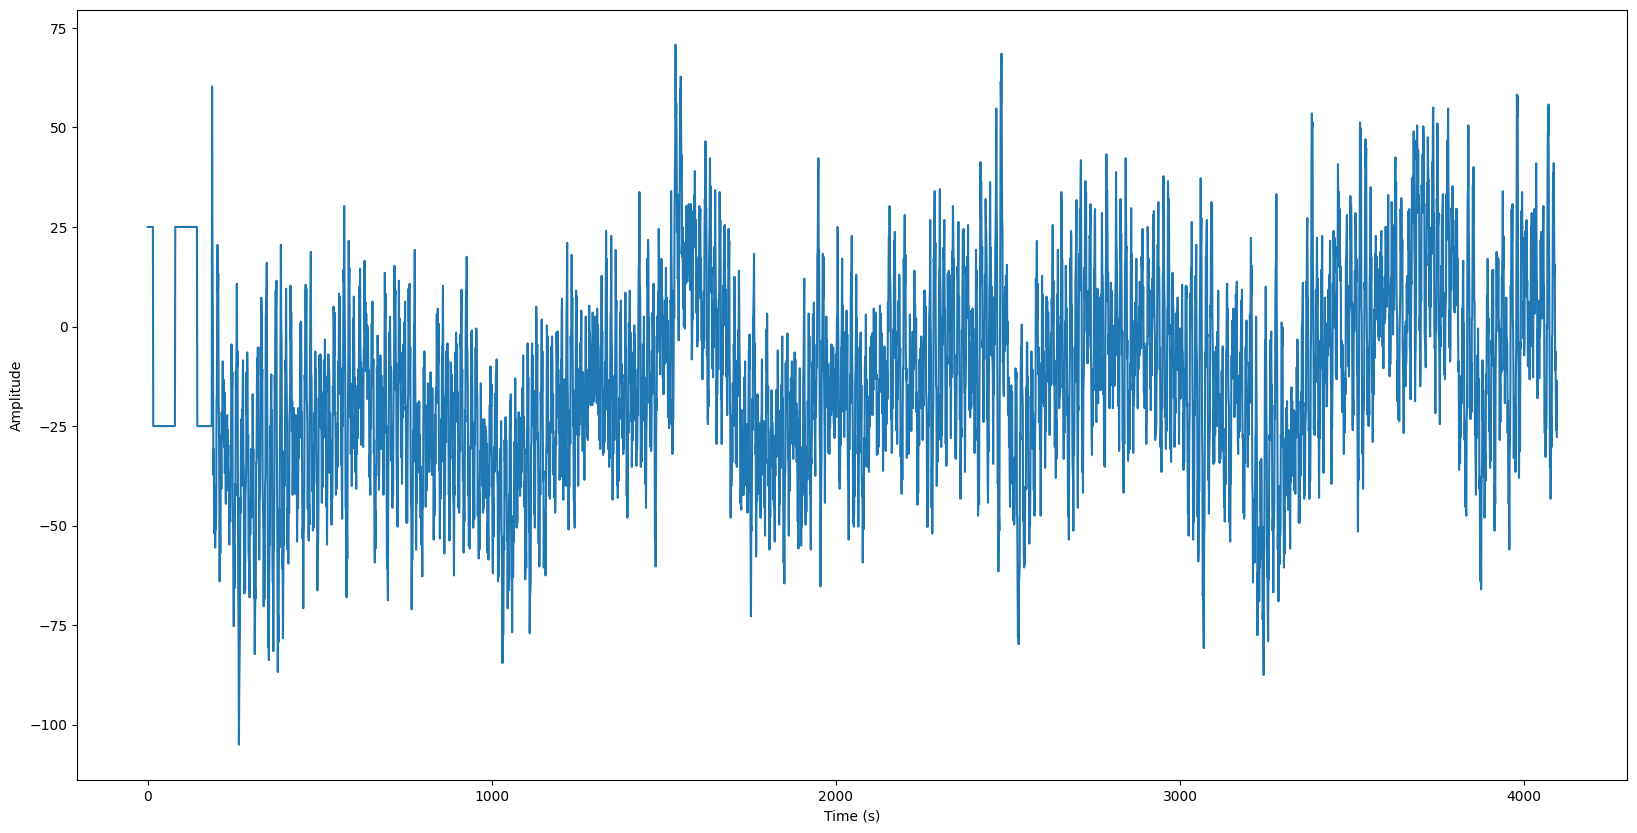

In [52]:
signal = eeg_array[1][:4096]
print(signal.shape)
plt.figure(figsize=(20,10))
plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Dataset 3: (.set) 88 data subjects

Source: https://www.kaggle.com/datasets/sravyaedara/eeg-signals-of-alzhiemers

Dataset contains the EEG resting state-closed eyes recordings from 88 subjects in total (36 Alzheimer's disease (AD group), 23 Frontotemporal Dementia (FTD group) and 29 were healthy subjects (CN group)).
                                                        
Recordings: 19 scalp electrodes (Fp1, Fp2, F7, F3, Fz, F4, F8, T3, C3, Cz, C4, T4, T5, P3, Pz, P4, T6, O1, and O2). The sampling rate was 500 Hz with 10uV/mm resolution.

Each recording lasted approximately 13.5 minutes for AD group (min=5.1, max=21.3), 12 minutes for FTD group (min=7.9, max=16.9) and 13.8 for CN group (min=12.5, max=16.5). In total, 485.5 minutes of AD, 276.5 minutes of FTD and 402 minutes of CN recordings were collected and are included in the dataset.
                                 
A complete analysis of this dataset can be found in the published Data Descriptor paper "A Dataset of Scalp EEG Recordings of Alzheimer’s Disease, Frontotemporal Dementia and Healthy Subjects from Routine EEG", https://doi.org/10.3390/data8060095

In [41]:
path_data3 = '/content/drive/My Drive/new_88_data/derivatives'
path_test = '/content/drive/My Drive/new_88_data/derivatives/sub-080/eeg/sub-080_task-eyesclosed_eeg.set'

In [42]:
df = pd.read_table('/content/drive/My Drive/new_88_data/derivatives/participants.tsv')
print(df)

   participant_id Gender  Age Group  MMSE
0         sub-001      F   57     A    16
1         sub-002      F   78     A    22
2         sub-003      M   70     A    14
3         sub-004      F   67     A    20
4         sub-005      M   70     A    22
..            ...    ...  ...   ...   ...
83        sub-084      F   71     F    24
84        sub-085      M   64     F    26
85        sub-086      M   49     F    26
86        sub-087      M   73     F    24
87        sub-088      M   55     F    24

[88 rows x 5 columns]


In [43]:
df.Group.value_counts()

## Group
# "A": "Alzheimer Disease Group"
# "F": "Frontotemporal Dementia Group"
# "C": "Healthy Group

Group
A    36
C    29
F    23
Name: count, dtype: int64

In [44]:
raw = mne.io.read_raw_eeglab(path_test)
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>

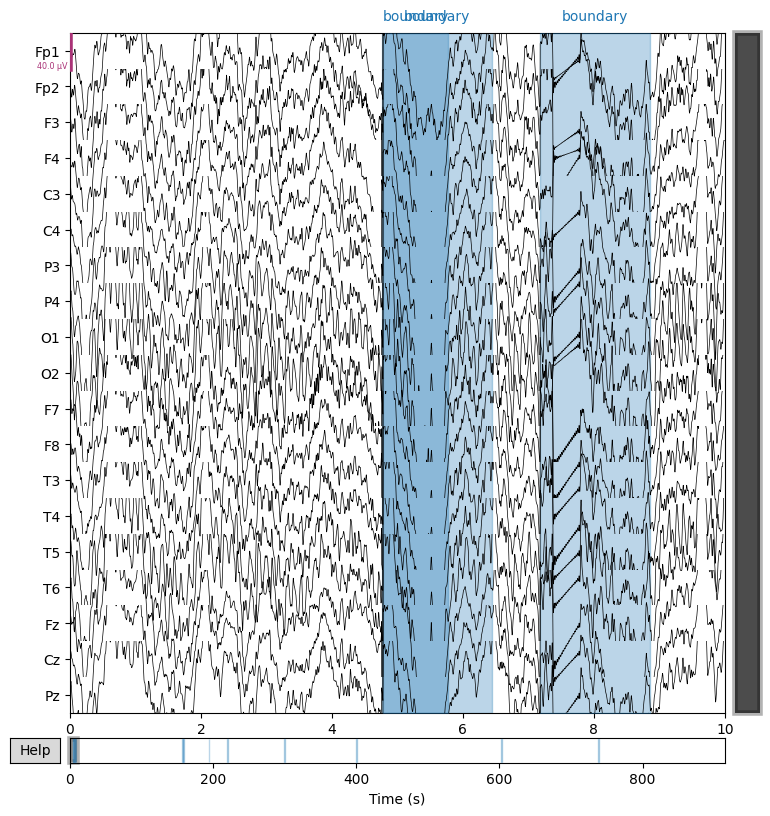

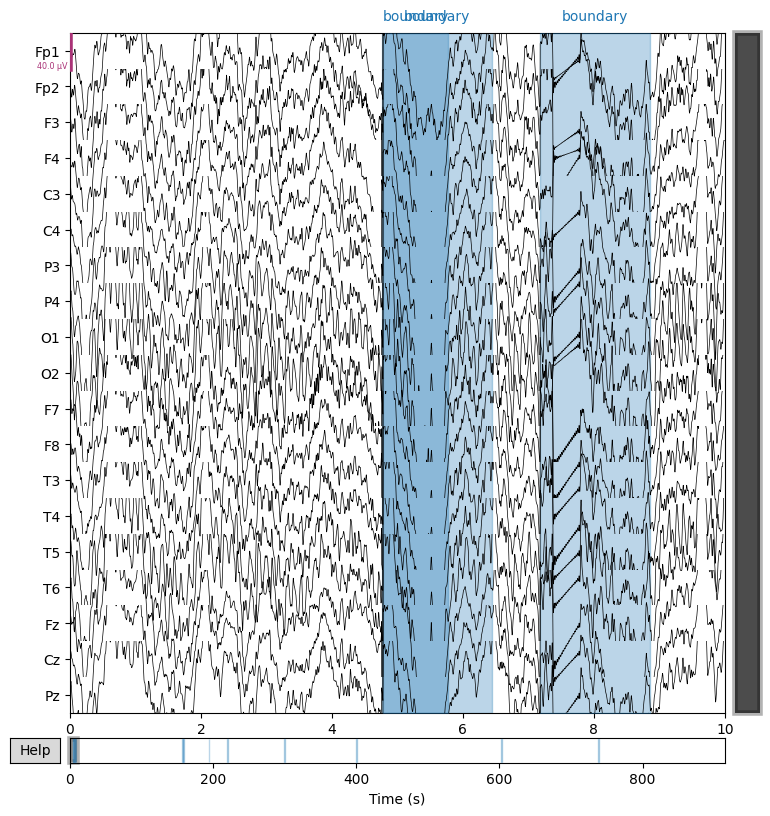

In [45]:
raw.plot()

In [54]:
data = raw.get_data()
print(data.shape)
print(data[:,:3])

(19, 457570)
[[-7.05149508e-06 -6.21660852e-06 -5.46901274e-06]
 [-1.27079687e-05 -1.13839407e-05 -1.00943489e-05]
 [-8.22858429e-06 -6.59693480e-06 -5.18390226e-06]
 [-8.45705509e-06 -8.99048805e-06 -9.78073120e-06]
 [-2.27081013e-06  3.60837281e-07  2.55709887e-06]
 [-7.34820080e-06 -7.49642229e-06 -7.42107153e-06]
 [-2.10060954e-06  6.33360147e-07  3.30210543e-06]
 [-1.63459551e-06 -1.32573116e-06 -5.52043915e-07]
 [ 2.88578439e-06  5.22015715e-06  7.76904869e-06]
 [ 5.32069492e-06  6.72792625e-06  8.43993282e-06]
 [-8.98645020e-06 -7.07795048e-06 -4.85944891e-06]
 [-9.39240265e-06 -9.27022362e-06 -8.92412567e-06]
 [-5.33746958e-06 -3.43788028e-06 -1.72596765e-06]
 [-6.55703020e-06 -7.16894579e-06 -7.41984224e-06]
 [-7.23184109e-07  1.06711972e-06  2.82155728e-06]
 [-7.41138756e-07 -7.50503421e-07 -2.68686593e-07]
 [-4.39124775e-06 -3.31135702e-06 -2.27017641e-06]
 [-6.06325722e-06 -4.54114628e-06 -2.83870625e-06]
 [-1.60927355e-06  4.13051322e-08  2.01093531e-06]]


In [55]:

path_test_2 = '/content/drive/My Drive/new_88_data/derivatives/sub-001/eeg/sub-001_task-eyesclosed_eeg.set'
raw_2 = mne.io.read_raw_eeglab(path_test_2)
data_2 = raw_2.get_data()
print(data_2.shape)

(19, 299900)


In [47]:
# # subject = "01"
# # task = "somato"
# # raw_fname = data_path / f"sub-{subject}" / "meg" / f"sub-{subject}_task-{task}_meg.fif"


# # Participant ID code
# p_id = 'sub-001'
# data_dir = 'data/' + p_id + '/'

# # create string containing file name
# raw_file = data_dir + p_id + '.vhdr'


# Data Preparation

# Models